In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Type
from scipy.stats import norm
from tqdm import tqdm

## Modelo de Heston:


$$ dS = \mu S dt + \sqrt{V} S dW_{1} $$

$$ dV = \kappa (\theta - V) dt + \xi \sqrt{V} dW_{2}   $$

$S_0$: valor inicial do ativo

$S$: preço do ativo

$\mu$: retorno médio

$V$: variância do ativo

$\theta$: variância assintótica (variância quando $t -> \infty$)

$\kappa$: velocidade de retorno a média (taxa que $E[V] \rightarrow \theta$)

$\xi$: volatilidade da volatilidade (variância de $V$)

$v_0$: volatilidade inicial

$dW_1dW_2 = \rho dt$: $\rho$ e a correlação entre $W_1$ e $W_2$

In [2]:
# Criando a classe para representar o modelo de heston

class HestonModel:
    def __init__(self,
                 mu:float, kappa:float, theta:float,
                 qsi:float) -> None:
        """Class to represent a SDE that has the structure of the heston model."""
        self.mu = mu
        self.kappa = kappa
        self.theta = theta
        self.qsi = qsi

    def get_MU_S(self, s:float) -> float:
        return self.mu * s

    def get_SIGMA_S(self, s:float, v:float) -> float:
        return np.sqrt(v) * s

    def get_dx_SIGMA_S(self, v:float) -> float:
        return np.sqrt(v)

    def get_MU_V(self, v:float) -> float:
        return self.kappa * (self.theta - v)

    def get_SIGMA_V(self, v:float) -> float:
        return self.qsi * np.sqrt(v)

    def get_dx_SIGMA_V(self, v:float) -> float:
        return self.qsi / (2*np.sqrt(v))

In [3]:
# Função que retorna os incrementos dos movimentos brownianos

def dW(dt:float, T:int, rho) -> np.ndarray:
        cov_matrix = np.array([[      dt,      rho * dt],
                               [rho * dt,       dt     ]])
        time_grid = np.arange(0, T, dt)
        dWs_inc = np.random.multivariate_normal([0, 0], cov=cov_matrix, size=len(time_grid))
        return dWs_inc

In [4]:
# Função Euler Maruyama para resolver as SDES

def Euler_Maruyama(model: Type[HestonModel], dt:float=0.001, t0:float=0, T:float=1, s0:Type[List]=1, v0:Type[List]=0.05, dWs_inc:Type[List]=[]):
    """Euler Maruyama for resolving the SDE
    model: model of the SDE system
    dt: delta_t
    t0: start time
    T: time of maturity
    S0: inicial value of the asset
    V0: inicial value of the volatility of the asset"""

    time_grid = np.arange(0, T, dt)

    S = [s0]
    V = [v0]

    for i, dW in enumerate(dWs_inc[1:]):
        V_next = V[i] + model.get_MU_V(V[i]) * dt + model.get_SIGMA_V(V[i]) * dW[1]
        
        if V_next < 0:
            V_next = -V_next
            
        S_next = S[i] + model.get_MU_S(S[i]) * dt + model.get_SIGMA_S(S[i], V[i]) * dW[0]
        

        V.append(V_next)
        S.append(S_next)
    return time_grid, np.array(S), np.array(V)


In [5]:
# Função Milstein para resolver as SDES

def Milstein(model:Type[HestonModel], dt:float=0.001, t0:float=0, T:float=1, s0:Type[List]=1, v0:Type[List]=0.05, dWs_inc:Type[List]=[]):
    """Milstein method for resolving the SDE, has a higher order of convergence then EM
    model: model of the SDE system
    dt: delta_t
    t0: start time
    T: time of maturity
    s0: inicial value of the asset
    v0: inicial value of the volatility of the asset"""
    time_grid = np.arange(0, T, dt)

    S = [s0]
    V = [v0]

    for i, dW in enumerate(dWs_inc[1:]):
        V_next = V[i] + model.get_MU_V(V[i]) * dt + model.get_SIGMA_V(V[i])       * dW[1] + 0.5 * model.get_SIGMA_V(V[i])       * model.get_dx_SIGMA_V(V[i]) * (dW[1]**2 - dt)
        if V_next < 0:
            V_next = -V_next
        
        S_next = S[i] + model.get_MU_S(S[i]) * dt + model.get_SIGMA_S(S[i], V[i]) * dW[0] + 0.5 * model.get_SIGMA_S(S[i], V[i]) * model.get_dx_SIGMA_S(V[i]) * (dW[0]**2 - dt)
        

        V.append(V_next)
        S.append(S_next)

    return time_grid, np.array(S), np.array(V)

In [6]:
# Constantes do modelo e algumas outras variáveis
t0 = 0.0
T = 1.0
N = 1000
dt = T/N

mu = 1.0
kappa = 1.0
theta = 1.0
qsi = 1
s0 = 0.5
v0 = 0.5
rho = 0.2

if 2 * kappa * theta <= qsi**(2):
  print('Mude os parâmetros para a condição de Feller for Satisfeita')
else:
  print('A condição de Feller foi satisfeita!')

A condição de Feller foi satisfeita!


In [7]:
# Criação do objeto usando a classe Heston
obj = HestonModel(mu, kappa, theta, qsi)

In [8]:
# Criando os incrementos com a aleatoriedade controlada para fazer sanities checks
np.random.seed(0)

dWs_inc = dW(dt=dt, T=T, rho=rho)

In [9]:
# Testando o método EM e Mils

ts, s_EM, v_EM = Euler_Maruyama(obj, dt=dt, t0=t0, T=T, s0=s0, v0=v0, dWs_inc=dWs_inc)

ts, s_MILS, v_EM = Milstein(obj, dt=dt, t0=t0, T=T, s0=s0, v0=v0, dWs_inc=dWs_inc)


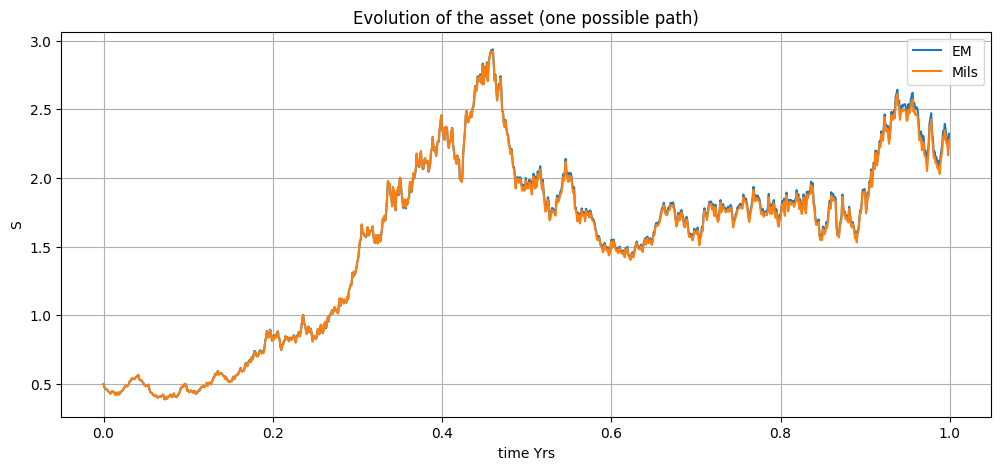

In [10]:
# Plotando o gráfico e tesntando o programa

plt.figure(figsize=(12,5))
plt.plot(ts, s_EM, label='EM')
plt.plot(ts, s_MILS, label='Mils')
plt.title('Evolution of the asset (one possible path)')
plt.xlabel('time Yrs')
plt.ylabel('S')
plt.legend()
plt.grid()
plt.show()